In [12]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import shape
import numpy as np

In [2]:
# Load the shapefile containing the parcels
gdf = gpd.read_file("/Users/placiermoise/Documents/dsw_proj/Parcelles/RPG_2023/PARCELLES_GRAPHIQUES.gpkg")

In [ ]:
# Convert the CRS to WGS 84 (EPSG:4326)
# This is necessary for compatibility with other datasets and for visualization purposes.
# The original CRS of the shapefile is EPSG:31370, which is a Belgian Lambert 72 / Belgian Lambert 73 projection.
# Converting to EPSG:4326 allows for easier integration with web mapping services and other geospatial data.
gdf  = gdf.to_crs(epsg=4326)

In [ ]:

######### add numeric label 

Label_culture = pd.read_csv("REF_CULTURES_GROUPES.csv", sep=";")
Label_culture["Label"] = pd.to_numeric(Label_culture["Label"], errors="coerce").astype("Int64")
Label_culture["Label"] = Label_culture["Label"].fillna(0).astype(int)


gdf = gdf.merge(Label_culture[["Label","CODE_CULTURE"]], how="left", left_on="CODE_CULTU", right_on="CODE_CULTURE") #TODO check if this is right (CODE_CULTU)

gdf = gdf.rename(columns={"Label": "LABEL"})


In [9]:
gdf

NameError: name 'gdf' is not defined

In [5]:
import ee 
import geemap

/Users/placiermoise/Documents/remote sensing crop classification/.venv/lib/python3.12/site-packages/geemap/conversion.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
ee.Authenticate(scopes=['https://www.googleapis.com/auth/earthengine',
                        'https://www.googleapis.com/auth/drive'])
ee.Initialize()

NameError: name 'ee' is not defined

In [7]:
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# Draw a polygon on the map

polygone_hand_draw = Map.draw_features  

first_polygone = polygone_hand_draw[0] 

geom_hand_poly = first_polygone.geometry()

geom_hand_poly

Map.addLayer(geom_hand_poly, {}, "Polygone dessiné")

In [ ]:
#  Convert the GEE geometry to GeoJSON format
# This is necessary to convert the GEE geometry into a format that can be used with shapely.  
geom_hand_poly_json = geom_hand_poly.getInfo()

#  Convert the GeoJSON to a shapely geometry
# This allows us to use the shapely library to manipulate and analyze the geometry.
hand_poly_shapely = shape(geom_hand_poly_json)


# Filter the GeoDataFrame to keep only the parcels that are within the drawn polygon
# This uses the shapely geometry to check if each parcel's geometry is within the drawn polygon.
# The 'within' method checks if the geometry of each parcel is completely contained within the polygon.
gdf_contained = gdf[gdf.geometry.within(hand_poly_shapely)]

# Convert the filtered GeoDataFrame to GeoJSON format
# This allows us to use the filtered data in other applications or for further processing.
Parcelle_within_hand_Poly_geojson = gdf_contained.__geo_interface__

# Convert the GeoDataFrame to an Earth Engine FeatureCollection
# This allows us to use the filtered data in Earth Engine for further analysis or visualization.
fc = geemap.geopandas_to_ee(gdf_contained, geodesic=False)
fc_geom = fc.geometry()

Map.addLayer(fc_geom, {}, "parcelles")

In [10]:
############ Import raster from the selected zone (hand poly )


Geometry_data_collect = geom_hand_poly

# Get the area value
area_m2 = geom_hand_poly.area(maxError=1)
print("Area (m²):", area_m2.getInfo())

Area (m²): 30411058.04554169


In [ ]:
from datetime import datetime, timedelta


start_date = '2023-01-01'
end_date = '2023-12-31'
bands = ['B2', 'B3', 'B4', 'B8']

# Generate half-monthly date ranges
def generate_half_month_ranges(start_date, end_date):
    date_list = []
    current = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')

    while current < end:
        mid = current + timedelta(days=15)
        end_of_month = (current.replace(day=28) + timedelta(days=4)).replace(day=1)

        date_list.append((current.strftime('%Y-%m-%d'), min(mid, end).strftime('%Y-%m-%d')))
        date_list.append((min(mid, end).strftime('%Y-%m-%d'), min(end_of_month, end).strftime('%Y-%m-%d')))

        current = end_of_month

    return date_list

def generate_date_ranges(start_date, end_date, interval_days=15):
    """
    Génère des intervalles de dates de `interval_days` jours entre `start_date` et `end_date`.

    Args:
        start_date (str): Date de début au format 'YYYY-MM-DD'.
        end_date (str): Date de fin au format 'YYYY-MM-DD'.
        interval_days (int): Longueur de chaque intervalle en jours.

    Returns:
        List[Tuple[str, str]]: Liste de tuples (date_début, date_fin).
    """
    date_list = []
    current = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')

    while current < end:
        next_date = current + timedelta(days=interval_days)
        date_list.append((
            current.strftime('%Y-%m-%d'),
            min(next_date, end).strftime('%Y-%m-%d')
        ))
        current = next_date

    return date_list

# Generate date ranges with a 30-day interval
#ranges = generate_half_month_ranges(start_date, end_date)
ranges = generate_date_ranges(start_date, end_date, interval_days=30)

In [ ]:
def mask_scl(img):
    scl = img.select('SCL')
    # Mask all pixels that are NOT in classes 4 to 7
    mask = (scl.eq(4)
           .Or(scl.eq(5))
           .Or(scl.eq(6))
           .Or(scl.eq(7)))
    return img.updateMask(mask)

def get_median_image(start, end, Geometry_data_collect):
    # Load the useful bands + SCL
    collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
        .filterBounds(Geometry_data_collect) \
        .filterDate(start, end) \
        .map(lambda img: img.clip(Geometry_data_collect)) \
        .map(mask_scl) \
        .select(bands)

    def compute_median():
        return collection.median() \
            .set('system:time_start', ee.Date(start).millis()) \
            .set('start_date', start) \
            .set('end_date', end) \
            .set('Number_of_aggreted_images', size)

    size = collection.size()
    median = ee.Algorithms.If(size.gt(0), compute_median(), None)
    return median

# Create a list of median images for each date range
median_images = [get_median_image(start, end, Geometry_data_collect) for start, end in ranges]

# Create a collection from the images
s2 = ee.ImageCollection(median_images)

# Example: print the size of the collection
print("Number of median images:", s2.size().getInfo())


Nombre d'images médianes : 12


In [ ]:
s2_list = s2.toList(s2.size())
n_images = s2.size().getInfo()
total_n_img = 0
for i in range(n_images):
    img = ee.Image(s2_list.get(i))
    props = img.toDictionary().getInfo()
    
    num_agg = props['Number_of_aggreted_images']
    total_n_img += num_agg
    print(f"Image {i} composed by {num_agg} images " )

print(total_n_img)

Image 0 composée de 6 images 
Image 1 composée de 6 images 
Image 2 composée de 6 images 
Image 3 composée de 6 images 
Image 4 composée de 6 images 
Image 5 composée de 6 images 
Image 6 composée de 7 images 
Image 7 composée de 6 images 
Image 8 composée de 6 images 
Image 9 composée de 6 images 
Image 10 composée de 6 images 
Image 11 composée de 6 images 
73


In [ ]:

# Define visualization parameters for Sentinel-2 imagery
# (Red: B4, Green: B3, Blue: B2)
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # RGB
    'min': 0,
    'max': 3000,
    'gamma': 1.3
}

# Center the map on the feature collection (fc)
Map.centerObject(fc, zoom=10)  

img_n = 6

s2_list = s2.toList(s2.size())
image = ee.Image(s2_list.get(img_n))
Map.addLayer(geom_hand_poly, {}, "Polygone dessiné")
Map.addLayer(image, vis_params, f'Sentinel-2 RGB {img_n}')

Map

Map(bottom=765715.0, center=[43.64500738037024, 1.0472463503494793], controls=(WidgetControl(options=['positio…

In [ ]:
# Export the images to Google Drive as TIFF files
def export_tiff(image_collection,Geometry_data_collect,export_folder,export_maxPixels ): 
    # pixel overlap

    image_list = image_collection.toList(image_collection.size())
    n = image_collection.size().getInfo()
    
    for i in range(n):
        image = ee.Image(image_list.get(i)).clip(Geometry_data_collect)
        
        # Build a unique name, for example acquisition date
        date_str = image.date().format('YYYYMMdd').getInfo()
        task = ee.batch.Export.image.toDrive(
            image=image,
            description= "export",
            folder=export_folder,
            fileNamePrefix=f'sentinel2_{date_str}',
            region=Geometry_data_collect,
            scale=10,
            crs='EPSG:4326',
            maxPixels=export_maxPixels
        )
        task.start()
        print(f"Export started for image {i+1}/{n}, date : {date_str}")

In [ ]:
# export to TIFF format
image_collection = s2
export_folder = 'GEE_export_6_median'
export_maxPixels = 1e10


export_tiff(image_collection,Geometry_data_collect,export_folder,export_maxPixels )

Export lancé pour l’image 1/12, date : 20230101
Export lancé pour l’image 2/12, date : 20230131
Export lancé pour l’image 3/12, date : 20230302
Export lancé pour l’image 4/12, date : 20230401
Export lancé pour l’image 5/12, date : 20230501
Export lancé pour l’image 6/12, date : 20230531
Export lancé pour l’image 7/12, date : 20230630
Export lancé pour l’image 8/12, date : 20230730
Export lancé pour l’image 9/12, date : 20230829
Export lancé pour l’image 10/12, date : 20230928
Export lancé pour l’image 11/12, date : 20231028
Export lancé pour l’image 12/12, date : 20231127


In [ ]:
# Pixel Count
s2_first_img = ee.Image(s2.first())  # or .mosaic() if you want to avoid the clouds

# Option 1 : pixelCount
pixel_count = s2_first_img.select('B2').reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=Geometry_data_collect,
    scale=10,
    maxPixels=1e9
)

print("Number of valid pixels in B2 :", pixel_count.getInfo()['B2'])

Nombre de pixels valides dans B2 : 141726


In [37]:
import os as os
import tqdm 
import rasterio as rasterio
base_dir = "../data/Tif"

[[30 30 30 ... 30 30 30]
 [30 30 30 ... 30 30 30]
 [30 30 30 ... 30 30 30]
 ...
 [30 30 30 ...  8  8  8]
 [30 30 30 ...  8  8  8]
 [30 30 30 ...  8  8  8]]
Unique IDs: [ 0  3  4  6  7  8  9 10 14 15 16 17 18 20 21 22 28 29 30 31 33 36 41 42
 45 46 47 48 49]
[ 0  6  7  8 20 22 30 36 41 45]


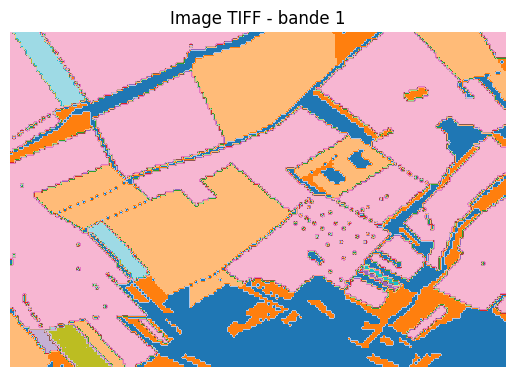

In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the TIFF file
with rasterio.open('../data/Tif/zone32/labels_raster_masked.tif') as src:
    img = src.read(1) 
    print(img)

    # img.shape = (H, W)
    H  , W = img.shape[:2]
    zoom_factor = 8

    # Taille du patch zoomé
    zoom_h = H // zoom_factor
    zoom_w = W // zoom_factor

    # Exemple : zoomer sur le coin supérieur droit
    zoomed_img = img[0:zoom_h, W - zoom_w:W]
    unique_ids = np.unique(zoomed_img)
    print(unique_ids)


    


plt.imshow(zoomed_img, cmap='tab20')  # or 'viridis', 'jet', etc.

plt.title('Image TIFF - bande 1')
plt.axis('off')
plt.show()


#src.close()

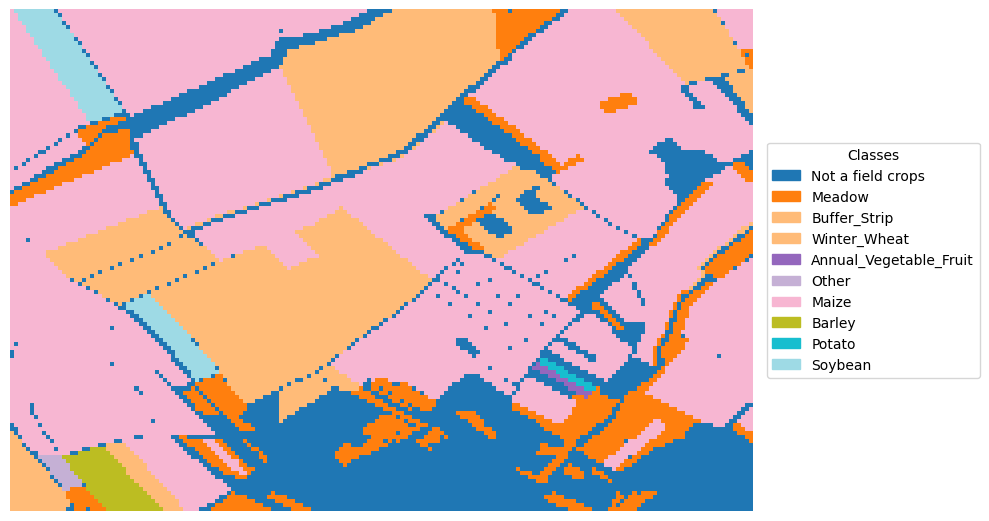

In [62]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import rasterio

# Ton label_map
label_map = {
    1: "Garlic", 2: "Winter_Oat", 3: "Spring_Oat", 4: "Winter_Durum_Wheat", 5: "Spring_Durum_Wheat",
    6: "Meadow", 7: "Buffer_Strip", 8: "Winter_Wheat", 9: "Beet", 10: "Spring_Wheat",
    11: "Carrot", 12: "Cucumber_Gherkin", 13: "Buckwheat", 14: "Sorghum", 15: "Winter_Rye",
    16: "Fodder", 17: "Rapeseed", 18: "Spelt", 19: "Spinach", 20: "Annual_Vegetable_Fruit",
    21: "Perennial_Vegetable_Fruit", 23: "Hops", 24: "Lavender_Lavandin", 25: "Lettuce_Batavia_Oak_Leaf",
    26: "Grain_Lentil", 27: "Spring_Oil_Flax", 28: "Alfalfa", 29: "Forage_Legume_Cereal_Oilseed_Mix",
    30: "Maize", 31: "Forage_Legume_Mix", 32: "Melon", 33: "Early_Proteaginous_Cereal_Mix",
    34: "Onion_Shallot", 35: "Olive", 36: "Barley", 37: "Chickpea", 38: "Winter_Pea",
    39: "Pumpkin_Red_Kuri", 40: "Early_Spring_Pea", 41: "Potato", 42: "Williams_Pear",
    43: "Vineyard", 44: "Sainfoin", 45: "Soybean", 46: "Clover", 47: "Sunflower",
    48: "Winter_Triticale", 49: "Orchard", 0: "Not a field crops", 22: "Other"
}

# Ouvrir l'image raster
with rasterio.open('../data/Tif/zone32/labels_raster_masked.tif') as src:
    img = src.read(1)
    H, W = img.shape
    zoom_factor = 8
    zoom_h = H // zoom_factor
    zoom_w = W // zoom_factor
    zoomed_img = img[0:zoom_h, W - zoom_w:W]
    unique_ids = np.unique(zoomed_img)

# Palette de couleurs automatique
cmap = plt.get_cmap('tab20', np.max(unique_ids) + 1)

# Affichage de l'image
plt.figure(figsize=(10, 8))
im = plt.imshow(zoomed_img, cmap=cmap, vmin=0, vmax=np.max(unique_ids))
plt.axis('off')

# Générer les légendes
legend_elements = []
for cls_id in unique_ids:
    if cls_id in label_map:
        color = cmap(int(cls_id))  # Couleur dans la colormap
        patch = mpatches.Patch(color=color, label=label_map[int(cls_id)])
        legend_elements.append(patch)

# Afficher la légende en dehors du plot
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.01, 0.5), title="Classes")
plt.tight_layout()
plt.show()

In [62]:
import rasterio
from rasterio.features import rasterize
import geopandas as gpd

# Load annotation polygons (with a "class_id" field)
gdf_to_rasterize = gdf_contained

# Load a reference image to retrieve the size, transform, and projection
with rasterio.open('/Users/placiermoise/Library/CloudStorage/GoogleDrive-moise.placier@gmail.com/Mon Drive/GEE_export_6_median/sentinel2_2.tif') as src:
    meta = src.meta.copy()

# Rasterize 
shapes = ((geom, value) for geom, value in zip(gdf_to_rasterize.geometry, gdf_to_rasterize['LABEL']))
label_raster = rasterize(
    shapes,
    out_shape=(meta['height'], meta['width']),
    transform=meta['transform'],
    fill=0,  # background label
    dtype=rasterio.uint8
)

# Sauvegarder le raster labelisé
meta.update({'count': 1, 'dtype': rasterio.uint8})
with rasterio.open('labels_raster.tif', 'w', **meta) as dst:
    dst.write(label_raster, 1)

with rasterio.open('labels_raster.tif') as src:
    img = src.read(1)   # read the first band

plt.imshow(img, cmap='jet')  
plt.colorbar()
plt.title('Image TIFF - band 1')
plt.show()

NameError: name 'gdf_contained' is not defined

In [ ]:

with rasterio.open('labels_raster.tif') as src:
    img_reference = src.read(1)  # read the first band

img_reference

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(497, 850), dtype=uint8)

In [ ]:
import os
import argparse
import numpy as np
import h5py
import rasterio
from rasterio.windows import Window
from tqdm import tqdm


tif_dir = '/Users/placiermoise/Library/CloudStorage/GoogleDrive-moise.placier@gmail.com/Mon Drive/GEE_export_6_median/'

def mask_no_label(tif_dir):
    with rasterio.open('labels_raster.tif') as src:
        img_reference = src.read(1) # read the first band
    # Get all tif files sorted by date
    tif_files = sorted([os.path.join(tif_dir, f) for f in os.listdir(tif_dir) if f.endswith('.tif')])

    for tif_path in tqdm(tif_files, desc="mask for TIFF images"):
        with rasterio.open(tif_path) as src:
            data = src.read()  # Shape: (bands, height, width)
            profile = src.profile
            # Mask: True where the reference value is 0
            mask = (img_reference == 0)
            # Apply the mask to all bands
            data[:, mask] = 0
        # Saving to a new file
        base_name = os.path.basename(tif_path).replace('.tif', '_masked.tif')
        output_path = os.path.join('data/Tif', base_name)

       # Writing the masked file
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(data)

mask_no_label(tif_dir)

mask des TIF: 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]


In [60]:
import h5py
import os

# Path to your HDF5 file
h5_path = '../data/dataset.h5'

# File size on disk (in MB)
file_size_mb = os.path.getsize(h5_path) / (1024 * 1024)
print(f"File size: {file_size_mb:.2f} MB")

# Open and inspect the content
with h5py.File(h5_path, 'r') as f:
    print("\nKeys found in the HDF5 file:")
    for key in f.keys():
        data = f[key]
        print(f"- {key} : shape={data.shape}, dtype={data.dtype}")

File size: 259.84 MB

Keys found in the HDF5 file:
- ID_Parcelles : shape=(7938, 24, 24), dtype=float32
- coords : shape=(7938, 2), dtype=float64
- data : shape=(7938, 12, 4, 24, 24), dtype=float32
- dates : shape=(7938,), dtype=object
- labels : shape=(7938, 24, 24), dtype=float32
- zones : shape=(7938,), dtype=object


In [89]:
import os
print(os.getcwd())
# Exemple : changer vers un sous-dossier "data"
os.chdir("/Users/placiermoise/Documents/dsw_proj/remote sensing crop classification/manual_jobs")

/Users/placiermoise/Documents/dsw_proj/remote sensing crop classification/manual_jobs


In [13]:
import h5py
import numpy as np

with h5py.File("dataset_val_train.h5", "r") as f:
    zones = f["zones"][:].astype(str).flatten()
    unique_zones = np.unique(zones)

print("uniques label :", unique_zones)

 

uniques label : ['zone10' 'zone12' 'zone13' 'zone14' 'zone15' 'zone17' 'zone18' 'zone19'
 'zone2' 'zone20' 'zone21' 'zone23' 'zone24' 'zone25' 'zone26' 'zone28'
 'zone29' 'zone3' 'zone30' 'zone31' 'zone33' 'zone34' 'zone35' 'zone36'
 'zone38' 'zone39' 'zone4' 'zone40' 'zone41' 'zone5' 'zone7' 'zone8'
 'zone9']


In [ ]:
zones_sorted = sorted(zones, key=lambda z: float(z))

print(zones_sorted)


In [21]:
import h5py
import torch
from collections import Counter

h5_path = "data/Dataset.h5"

with h5py.File("/Users/placiermoise/Documents/dsw_proj/remote sensing crop classification/manual_jobs/dataset_val_train.h5", 'r') as f:
    Y = torch.tensor(f['labels'][:])  # Y: [N, H, W]

# Aplatir tous les labels en un seul vecteur
y_flat = Y.flatten().tolist()

# Compter le nombre d'occurrences par classe
class_counts = Counter(y_flat)

print("Nombre d'instances par classe :")
for cls, count in sorted(class_counts.items()):
    print(f"Classe {cls}: {count} pixels")

Nombre d'instances par classe :
Classe 0.0: 11718020 pixels
Classe 1.0: 24750 pixels
Classe 2.0: 46675 pixels
Classe 3.0: 22765 pixels
Classe 4.0: 747714 pixels
Classe 5.0: 31198 pixels
Classe 6.0: 2967772 pixels
Classe 7.0: 99263 pixels
Classe 8.0: 8976364 pixels
Classe 9.0: 1333572 pixels
Classe 10.0: 50023 pixels
Classe 11.0: 41048 pixels
Classe 12.0: 8746 pixels
Classe 13.0: 56286 pixels
Classe 14.0: 98330 pixels
Classe 15.0: 25367 pixels
Classe 16.0: 59358 pixels
Classe 17.0: 2062228 pixels
Classe 18.0: 39777 pixels
Classe 19.0: 12938 pixels
Classe 20.0: 31864 pixels
Classe 21.0: 47185 pixels
Classe 22.0: 100791 pixels
Classe 23.0: 15865 pixels
Classe 24.0: 91483 pixels
Classe 25.0: 45640 pixels
Classe 26.0: 46291 pixels
Classe 27.0: 107608 pixels
Classe 28.0: 689084 pixels
Classe 29.0: 51946 pixels
Classe 30.0: 5330944 pixels
Classe 31.0: 170163 pixels
Classe 32.0: 43973 pixels
Classe 33.0: 162037 pixels
Classe 34.0: 99178 pixels
Classe 35.0: 44903 pixels
Classe 36.0: 1666374 pix

In [22]:
class_counts.pop(255, None)
class_counts

Counter({0.0: 11718020,
         8.0: 8976364,
         30.0: 5330944,
         6.0: 2967772,
         43.0: 2726627,
         17.0: 2062228,
         36.0: 1666374,
         47.0: 1493462,
         9.0: 1333572,
         4.0: 747714,
         28.0: 689084,
         41.0: 628452,
         45.0: 477856,
         49.0: 203590,
         31.0: 170163,
         33.0: 162037,
         38.0: 131918,
         40.0: 131425,
         37.0: 119810,
         48.0: 109995,
         27.0: 107608,
         22.0: 100791,
         7.0: 99263,
         34.0: 99178,
         14.0: 98330,
         24.0: 91483,
         46.0: 85896,
         16.0: 59358,
         13.0: 56286,
         29.0: 51946,
         10.0: 50023,
         21.0: 47185,
         2.0: 46675,
         26.0: 46291,
         25.0: 45640,
         35.0: 44903,
         32.0: 43973,
         11.0: 41048,
         18.0: 39777,
         20.0: 31864,
         5.0: 31198,
         44.0: 26473,
         15.0: 25367,
         1.0: 24750,
         

/var/folders/5y/cg3f72r56ndb2p52h64tts3m0000gn/T/ipykernel_65949/2076475499.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=counts, palette='mako')


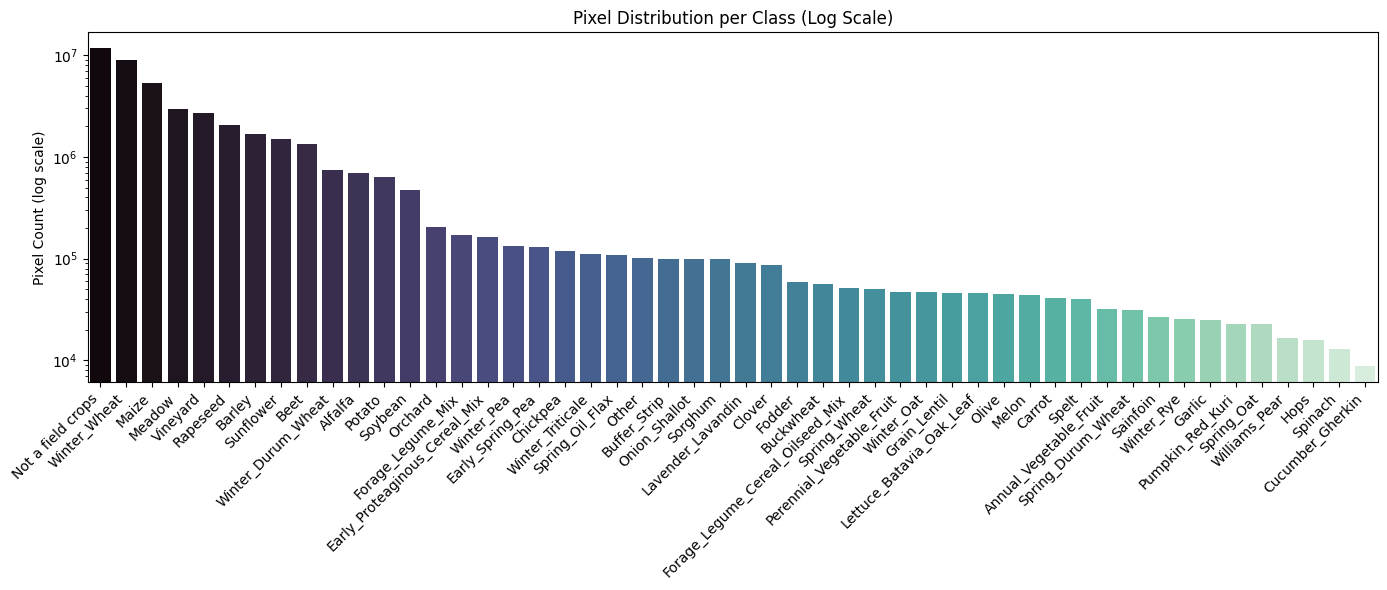

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
# Mapping vers noms lisibles (à adapter à ton dataset réel)
label_map = {
    1: "Garlic",
    2: "Winter_Oat",
    3: "Spring_Oat",
    4: "Winter_Durum_Wheat",
    5: "Spring_Durum_Wheat",
    6: "Meadow",
    7: "Buffer_Strip",
    8: "Winter_Wheat",
    9: "Beet",
    10: "Spring_Wheat",
    11: "Carrot",
    12: "Cucumber_Gherkin",
    13: "Buckwheat",
    14: "Sorghum",
    15: "Winter_Rye",
    16: "Fodder",
    17: "Rapeseed",
    18: "Spelt",
    19: "Spinach",
    20: "Annual_Vegetable_Fruit",
    21: "Perennial_Vegetable_Fruit",
    23: "Hops",
    24: "Lavender_Lavandin",
    25: "Lettuce_Batavia_Oak_Leaf",
    26: "Grain_Lentil",
    27: "Spring_Oil_Flax",
    28: "Alfalfa",
    29: "Forage_Legume_Cereal_Oilseed_Mix",
    30: "Maize",
    31: "Forage_Legume_Mix",
    32: "Melon",
    33: "Early_Proteaginous_Cereal_Mix",
    34: "Onion_Shallot",
    35: "Olive",
    36: "Barley",
    37: "Chickpea",
    38: "Winter_Pea",
    39: "Pumpkin_Red_Kuri",
    40: "Early_Spring_Pea",
    41: "Potato",
    42: "Williams_Pear",
    43: "Vineyard",
    44: "Sainfoin",
    45: "Soybean",
    46: "Clover",
    47: "Sunflower",
    48: "Winter_Triticale",
    49: "Orchard",
    0: "Not a field crops",      # Optional: Add NoData class if present
    22: "Other",       # Those blank 22s — label generically
}

# --- Mapping et tri décroissant ---
sorted_items = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
labels = [label_map.get(int(k), f"Class {int(k)}") for k, _ in sorted_items]
counts = [v for _, v in sorted_items]

# --- Affichage en échelle logarithmique ---
plt.figure(figsize=(14, 6))
ax = sns.barplot(x=labels, y=counts, palette='mako')

ax.set_yscale("log")  # Échelle log ici
plt.xticks(rotation=45, ha='right')
plt.ylabel("Pixel Count (log scale)")
plt.title("Pixel Distribution per Class (Log Scale)")
plt.tight_layout()
plt.show()

In [9]:
import h5py

# Ouvre le fichier
with h5py.File('dataset_test.h5', 'r') as f:
    # Liste les groupes/datasets au niveau racine
    def print_structure(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"{name}: shape={obj.shape}, dtype={obj.dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"{name} (Group)")

    f.visititems(print_structure)

ID_Parcelles: shape=(18704, 24, 24), dtype=float32
coords: shape=(18704, 2), dtype=float64
data: shape=(18704, 12, 4, 24, 24), dtype=float32
dates: shape=(18704,), dtype=object
labels: shape=(18704, 24, 24), dtype=float32
zones: shape=(18704,), dtype=object


In [80]:
import sys
sys.path.append("../data")
import data
from data import get_dataset_3splits
import importlib
importlib.reload(data)

import torch

train_loader, val_loader, test_loader = get_dataset_3splits(
    h5_path="../data/Dataset.h5",
    dataset_type="rf",      # ou "cnn"
    test_split_on="zone",
    batch_size=8,
    val_ratio=0.1,
    test_ratio=0.2,
    seed=42
)


# Récupère un batch du train loader
batch = next(iter(train_loader))
x, y = batch

print("x shape:", x.shape)
print("y shape:", y.shape)
print("x dtype:", x.dtype)
print("y dtype:", y.dtype)
print("y unique labels:", torch.unique(y))

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../data/Dataset.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [11]:
model = torch.load('URL=vscode-remote://ssh-remote%2Bkubernetes/storage/courses/CropIdentification/DSWProject_CropIdentification/models/best_model_cnn.pth')

FileNotFoundError: [Errno 2] No such file or directory: 'URL=vscode-remote://ssh-remote%2Bkubernetes/storage/courses/CropIdentification/DSWProject_CropIdentification/models/best_model_cnn.pth'